<h1><center><font size="6">Modeling, Feature Selection and Notebook</font></center></h1>

# <a id='0'>Contents</a>

- <a href='#1'>Importing Packages</a>
- <a href='#2'>Base Model</a>  
    - <a href='#21'>Logistic Regression</a>
    - <a href='#22'>Random Forest Classifier</a>
    - <a href='#23'>Decision Tree Classifier</a>
    - <a href='#24'>K-Nearest Neighbors</a>
    - <a href='#25'>Gaussian Naive Bayes Classifier</a>
    - <a href='#26'>Linear Discriminant Analysis</a>
    - <a href='#27'>AdaBoost Classifier</a>
    - <a href='#28'>Gradient Boosting Classifier</a>
    - <a href='#29'>XGBoost Classifier</a>
- <a href='#3'>Model with Engineered Features</a>
    - <a href='#31'>Logistic Regression</a>
    - <a href='#32'>Random Forest Classifier</a>
    - <a href='#33'>Decision Tree Classifier</a>
    - <a href='#34'>K-Nearest Neighbors</a>
    - <a href='#35'>Gaussian Naive Bayes Classifier</a>
    - <a href='#36'>Linear Discriminant Analysis</a>
    - <a href='#37'>AdaBoost Classifier</a>
    - <a href='#38'>Gradient Boosting Classifier</a>
    - <a href='#39'>XGBoost Classifier</a>
- <a href='#4'>Feature Selection</a>
    - <a href='#41'>Decision Tree Feature Importance</a>
    - <a href='#42'>Random Forest Feature Importance</a>
    - <a href='#43'>XGBoost Feature Importance</a>
    - <a href='#44'>Recursive Feature Elimination with Cross-Validation</a>
- <a href='#5'>Discussion of Evaluation Metrics</a>


# <a id='1'>Importing Packages</a>

In [2]:
import numpy as np 
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools
from collections import Counter


from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc, mean_squared_error, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import TomekLinks

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


%reload_ext autoreload
%autoreload 2

from utils import *

plt.style.use("fivethirtyeight")
sns.set_theme(style = "darkgrid", font = 'serif', context = 'poster')

# <a id='2'>Base Model</a>

In [3]:
train = pd.read_csv("../data/train_cleaned.csv")
validate = pd.read_csv("../data/validate_cleaned.csv")

In [4]:
train.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1785.87,2,2,1,44,0,0,0,0,0,...,798.64,845.04,979.41,107.72,178.69,107.15,107.15,178.59,33.00,0
1,5714.80,2,3,1,46,0,0,0,0,0,...,147.41,142.69,30.07,83.69,173.44,35.72,142.69,30.07,939.83,0
2,3571.75,2,2,1,47,0,0,0,0,0,...,223.95,-14.14,-14.14,238.09,0.00,223.95,0.00,0.00,0.00,1
3,6071.97,2,2,1,29,0,0,0,0,0,...,2282.45,1553.89,1571.39,79.83,89.04,92.33,60.11,67.90,75.40,0
4,5357.62,2,1,2,33,0,0,0,0,0,...,1195.07,992.95,80.76,964.62,1168.50,1195.64,993.23,80.76,6052.86,0


In [5]:
validate.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1071.52,1,2,2,25,0,0,0,0,0,...,449.33,489.90,529.62,53.58,71.43,53.58,53.58,53.58,71.43,0
1,5357.62,2,1,2,26,0,0,0,0,0,...,3628.22,2776.71,2759.67,160.23,151.26,112.90,94.54,95.33,95.33,0
2,2500.22,2,3,1,32,0,0,0,0,0,...,2491.40,2504.19,2507.80,86.83,111.15,107.15,87.08,89.29,91.22,0
3,4643.27,1,3,2,49,0,0,0,0,0,...,603.55,401.32,248.02,57.51,64.58,250.52,0.96,250.42,157.44,0
4,1785.87,2,2,2,36,0,0,0,0,0,...,699.13,724.89,694.31,71.43,53.58,35.72,64.29,0.00,35.72,1


In [6]:
X_train = train.drop(["default"], axis=1)
y_tr = train["default"]
X_validate = validate.drop(["default"], axis=1)
y_val = validate["default"]


In [7]:
# # Grab indices of columns for creating dummy variables and create dataframe with dummy variables
# dum_feat = X_train[['gender', 'education', 'marriage']]
# dum_index = dum_feat.columns
# tr_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar'])
# tr_dum.head()

In [8]:
# dum_feat = X_validate[['gender', 'education', 'marriage']]
# dum_index = dum_feat.columns
# val_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar'])
# val_dum.head()

In [9]:
# X_tr_dum = X_train.drop(['gender', 'education', 'marriage'], axis=1)
# X_tr_dum = X_tr_dum.join(tr_dum, how="left")
# X_val_dum = X_validate.drop(['gender', 'education', 'marriage'], axis=1)
# X_val_dum = X_val_dum.join(val_dum, how="left")

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)
X_val = scaler.transform(X_validate)

## <a id='21'>Logistic Regression</a>

Training Accuracy:  0.8207142857142857
Validation Accuracy:  0.8168333333333333
Training F1 Score:  0.4603697864411639
Validation F1 Score:  0.4372759856630825
Training AUC Score:  0.7615982535285184
Validation AUC Score:  0.7613570682370628
Training Recall Score:  0.3449312714776632
Validation Recall Score:  0.32520944402132523
Training Precision Score:  0.6919431279620853
Validation Precision Score:  0.6671875
Training Average Precision Score:  0.5357662754871487
Validation Average Precision Score:  0.5130659708957399

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.34      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.8

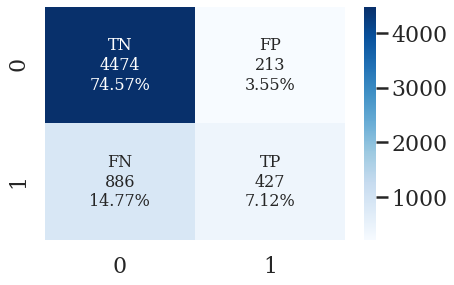

In [11]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr, y_tr)
y_pred_log_tr = logreg.predict(X_tr)
y_pred_log_val = logreg.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_log_tr, y_pred_log_val, logreg)

## <a id='22'>Random Forest Classifier</a>

Training Accuracy:  0.9994285714285714
Validation Accuracy:  0.8161666666666667
Training F1 Score:  0.9987110633727175
Validation F1 Score:  0.4616886285993167
Training AUC Score:  0.9999981471178933
Validation AUC Score:  0.7591511969959203
Training Recall Score:  0.9984965635738832
Validation Recall Score:  0.3602437166793602
Training Precision Score:  0.9989256553502364
Validation Precision Score:  0.6426630434782609
Training Average Precision Score:  0.9999932353501546
Validation Average Precision Score:  0.5149293451508552

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

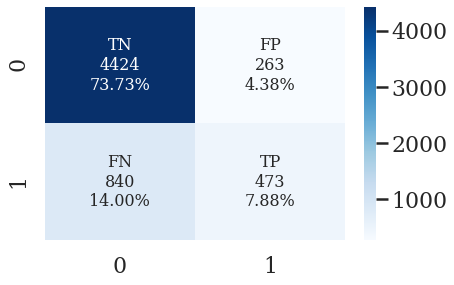

In [12]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_val = rfc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_rfc_tr, y_pred_rfc_val, rfc)

## <a id='13'>Decision Tree Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7263333333333334
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.3827067669172932
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6048645188820141
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.38766184310738766
Training Precision Score:  1.0
Validation Precision Score:  0.37787676317743135
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.2807316396250441

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83    

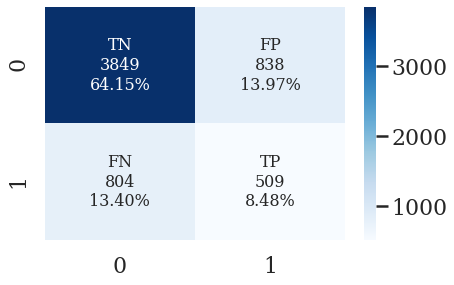

In [13]:
dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_val = dtc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_dtc_tr, y_pred_dtc_val, dtc)

## <a id='14'>K-Nearest Neighbors</a>

Training Accuracy:  0.843047619047619
Validation Accuracy:  0.795
Training F1 Score:  0.573829842254978
Validation F1 Score:  0.4409090909090909
Training AUC Score:  0.8808282078146316
Validation AUC Score:  0.7034749256219216
Training Recall Score:  0.47658934707903783
Validation Recall Score:  0.3693830921553694
Training Precision Score:  0.7209226770630279
Validation Precision Score:  0.5467869222096956
Training Average Precision Score:  0.6406080686603904
Validation Average Precision Score:  0.4197396446674167

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16344
           1       0.72      0.48      0.57      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.71      0.74     21000
weighted avg       0.83      0.84      0.83     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84     

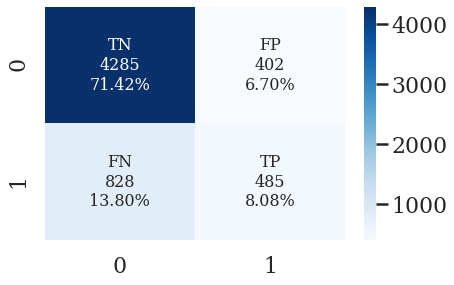

In [14]:
knn = KNeighborsClassifier().fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_val = knn.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_knn_tr, y_pred_knn_val, knn)

## <a id='15'>Gaussian Naive Bayes Classifier</a>

Training Accuracy:  0.7695238095238095
Validation Accuracy:  0.7656666666666667
Training F1 Score:  0.520126908586159
Validation F1 Score:  0.5097629009762901
Training AUC Score:  0.7484319229562684
Validation AUC Score:  0.7458567400781699
Training Recall Score:  0.5633591065292096
Validation Recall Score:  0.5567402894135567
Training Precision Score:  0.4830570902394107
Validation Precision Score:  0.470096463022508
Training Average Precision Score:  0.5028264895403012
Validation Average Precision Score:  0.48341103710889494

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     16344
           1       0.48      0.56      0.52      4656

    accuracy                           0.77     21000
   macro avg       0.68      0.70      0.68     21000
weighted avg       0.78      0.77      0.78     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

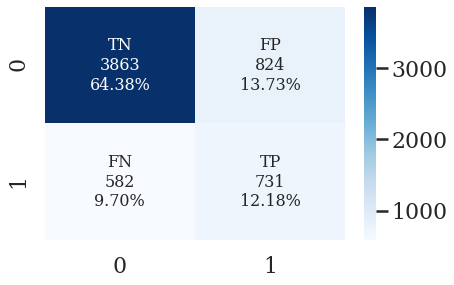

In [15]:
gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_val = gnb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gnb_tr, y_pred_gnb_val, gnb)

## <a id='17'>Linear Discriminant Analysis</a>

Training Accuracy:  0.8215714285714286
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.4799444829979181
Validation F1 Score:  0.4643564356435644
Training AUC Score:  0.7601189045697907
Validation AUC Score:  0.7575676820607501
Training Recall Score:  0.3713487972508591
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.6783052177324441
Validation Precision Score:  0.6633663366336634
Training Average Precision Score:  0.5343333116183251
Validation Average Precision Score:  0.5117838827258787

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.68      0.37      0.48      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.66      0.69     21000
weighted avg       0.81      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

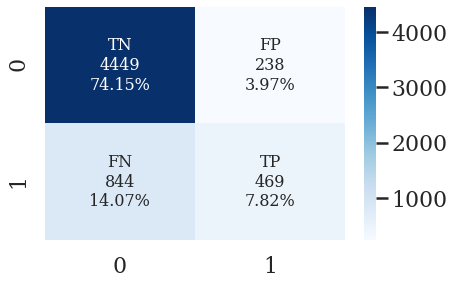

In [16]:
lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = lda.predict(X_tr)
y_pred_lda_val = lda.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_lda_tr, y_pred_lda_val, lda)

## <a id='16'>AdaBoost Classifier</a>

Training Accuracy:  0.819952380952381
Validation Accuracy:  0.8153333333333334
Training F1 Score:  0.4511540136449411
Validation F1 Score:  0.4235171696149844
Training AUC Score:  0.7873281037904132
Validation AUC Score:  0.7762876885085563
Training Recall Score:  0.3337628865979381
Validation Recall Score:  0.30997715156131
Training Precision Score:  0.6959247648902821
Validation Precision Score:  0.6683087027914614
Training Average Precision Score:  0.5585736608944247
Validation Average Precision Score:  0.5247647859929081

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.70      0.33      0.45      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0     

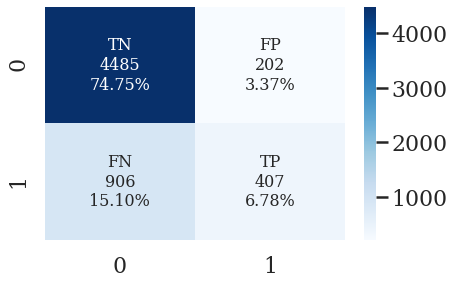

In [17]:
abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_val = abc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_abc_tr, y_pred_abc_val, abc)

## <a id='18'> Gradient Boosting Classifier</a>

Training Accuracy:  0.8287142857142857
Validation Accuracy:  0.8198333333333333
Training F1 Score:  0.5039304923458833
Validation F1 Score:  0.4645864289252105
Training AUC Score:  0.8093206777017491
Validation AUC Score:  0.7813591611741961
Training Recall Score:  0.39239690721649484
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.7040462427745665
Validation Precision Score:  0.6643059490084986
Training Average Precision Score:  0.6080316518725907
Validation Average Precision Score:  0.547847402743348

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.70      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.81      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

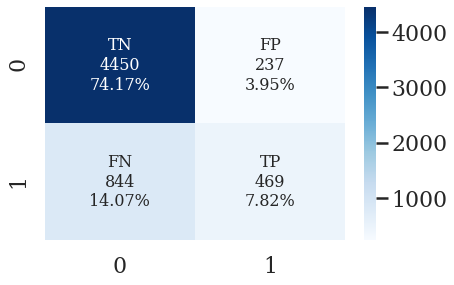

In [18]:
gbc = GradientBoostingClassifier().fit(X_tr, y_tr)
y_pred_gbc_tr = gbc.predict(X_tr)
y_pred_gbc_val = gbc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gbc_tr, y_pred_gbc_val, gbc)

## <a id='19'>XGBoost Classifier</a>

[09:08:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.891095238095238
Validation Accuracy:  0.8143333333333334
Training F1 Score:  0.6986427724337858
Validation F1 Score:  0.46493756003842457
Training AUC Score:  0.9490677926723217
Validation AUC Score:  0.7631011283498572
Training Recall Score:  0.569372852233677
Validation Recall Score:  0.3686214775323686
Training Precision Score:  0.9038527105352882
Validation Precision Score:  0.6293888166449935
Training Average Precision Score:  0.8672532450149335
Validation Average Precision Score:  0.5219345828970757

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16344
           1 

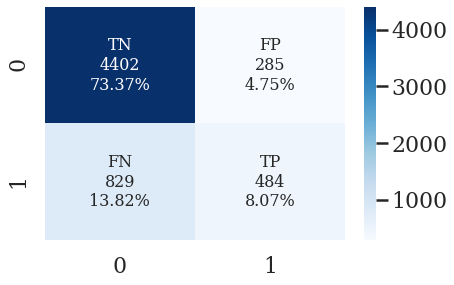

In [19]:
xgb = XGBClassifier().fit(X_tr, y_tr)
y_pred_xgb_tr = xgb.predict(X_tr)
y_pred_xgb_val = xgb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_xgb_tr, y_pred_xgb_val, xgb)

# <a id='2'>Modeling with Engineered Features</a>

In [20]:
train2 = pd.read_csv("../data/train_feature.csv")
validate2 = pd.read_csv("../data/validate_feature.csv")

In [21]:
train2.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,avail4,avail3,avail2,avail1,avg_av,pperb1,pperb2,pperb3,pperb4,pperb5
0,1784.92,2,2,1,44,0,0,0,0,0,...,0.552798,0.285940,0.161878,0.088441,0.344577,0.071973,0.140129,0.134174,0.126807,0.182341
1,5711.74,2,3,1,46,0,0,0,0,0,...,0.974206,0.969650,0.985388,0.844350,0.957227,1.002157,1.000000,0.242313,1.000000,1.000000
2,3569.84,2,2,1,47,0,0,0,0,0,...,0.937300,1.000000,0.933339,0.933339,0.968650,1.000000,0.000000,1.000000,-0.000000,-0.000000
3,6068.72,2,2,1,29,0,0,0,0,0,...,0.624100,0.627547,0.631912,0.534759,0.650602,0.035719,0.039375,0.040452,0.038685,0.043208
4,5354.75,2,1,2,33,0,0,0,0,0,...,0.776940,0.781986,0.821021,0.837380,0.836154,1.005968,1.000394,1.000477,1.000292,1.000000


In [22]:
validate2.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,avail4,avail3,avail2,avail1,avg_av,pperb1,pperb2,pperb3,pperb4,pperb5
0,1070.95,1,2,2,25,0,0,0,0,0,...,0.580662,0.613969,0.664597,0.704533,0.602048,0.149081,0.172706,0.119241,0.109366,0.101164
1,5354.75,2,1,2,26,0,0,0,0,0,...,0.322794,0.222106,0.162327,0.088426,0.293714,0.035701,0.036294,0.031117,0.034048,0.034544
2,2498.88,2,3,1,32,0,0,0,0,0,...,0.003526,0.020997,0.013142,-0.001745,0.005217,0.035190,0.045409,0.043011,0.034772,0.035608
3,4640.79,1,3,2,49,0,0,0,0,0,...,0.870016,0.875601,0.854184,0.840939,0.883482,0.084927,0.111794,0.415082,0.002393,1.009641
4,1784.92,2,2,2,36,0,0,0,0,0,...,0.608520,0.152780,0.047302,-0.884555,0.188228,0.041988,0.035412,0.051091,0.088696,0.000000


In [23]:
X_train2 = train2.drop(["default"], axis=1)
y_tr = train2["default"]
X_validate2 = validate2.drop(["default"], axis=1)
y_val = validate2["default"]

In [24]:
scaler = StandardScaler()
scaler.fit(X_train2)
X_tr2 = scaler.transform(X_train2)
X_val2 = scaler.transform(X_validate2)

## <a id='31'>Logistic Regression</a>

Training Accuracy:  0.8209047619047619
Validation Accuracy:  0.8163333333333334
Training F1 Score:  0.46047912781523453
Validation F1 Score:  0.4325437693099896
Training AUC Score:  0.7624345078450766
Validation AUC Score:  0.7559815672036752
Training Recall Score:  0.3447164948453608
Validation Recall Score:  0.31987814166031986
Training Precision Score:  0.693304535637149
Validation Precision Score:  0.6677265500794912
Training Average Precision Score:  0.536654359570969
Validation Average Precision Score:  0.5090781483592715

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.34      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

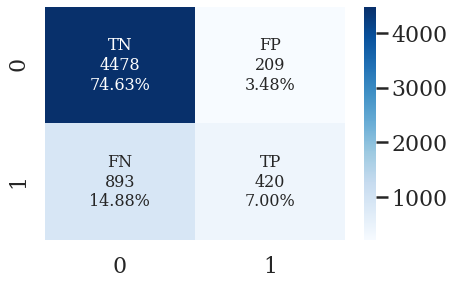

In [25]:
logreg2 = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr2, y_tr)
y_pred_log_tr2 = logreg2.predict(X_tr2)
y_pred_log_val2 = logreg2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_log_tr2, y_pred_log_val2, logreg2)

## <a id='32'>Random Forest Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.8155
Training F1 Score:  0.9988186016539576
Validation F1 Score:  0.4613138686131387
Training AUC Score:  0.9999902625131829
Validation AUC Score:  0.7553488924576428
Training Recall Score:  0.9987113402061856
Validation Recall Score:  0.361005331302361
Training Precision Score:  0.9989258861439313
Validation Precision Score:  0.6388140161725068
Training Average Precision Score:  0.9999638694190379
Validation Average Precision Score:  0.5129115001585514

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84    

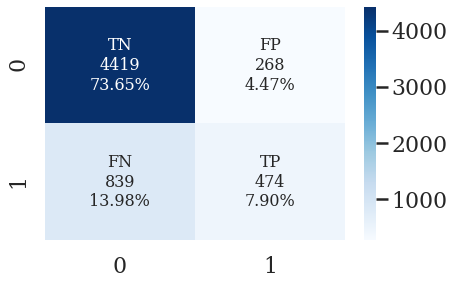

In [26]:
rfc2 = RandomForestClassifier().fit(X_tr2, y_tr)
y_pred_rfc_tr2 = rfc2.predict(X_tr2)
y_pred_rfc_val2 = rfc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_rfc_tr2, y_pred_rfc_val2, rfc2)

## <a id='33'>Decision Tree Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7208333333333333
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.38622205936240384
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6057209494069822
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.4013709063214014
Training Precision Score:  1.0
Validation Precision Score:  0.3721751412429379
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.2803802737509735

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83     

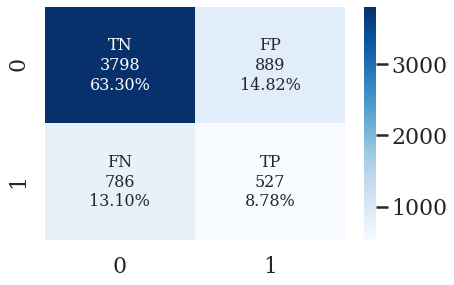

In [27]:
dtc2 = DecisionTreeClassifier().fit(X_tr2, y_tr)
y_pred_dtc_tr2 = dtc2.predict(X_tr2)
y_pred_dtc_val2 = dtc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_dtc_tr2, y_pred_dtc_val2, dtc2)

## <a id='34'>K-Nearest Neighbors</a>

Training Accuracy:  0.842
Validation Accuracy:  0.7925
Training F1 Score:  0.5688669438669439
Validation F1 Score:  0.42968392120934495
Training AUC Score:  0.8815190043152967
Validation AUC Score:  0.701184475671312
Training Recall Score:  0.47014604810996563
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.7200657894736842
Validation Precision Score:  0.539080459770115
Training Average Precision Score:  0.6365374339812295
Validation Average Precision Score:  0.4069967296752565

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16344
           1       0.72      0.47      0.57      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.71      0.74     21000
weighted avg       0.83      0.84      0.83     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.91      

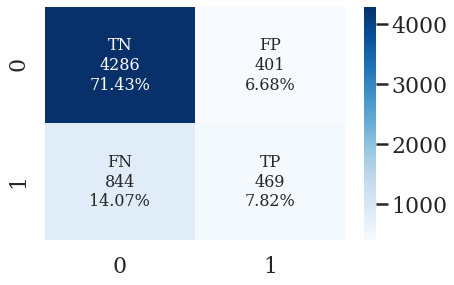

In [28]:
knn2 = KNeighborsClassifier().fit(X_tr2, y_tr)
y_pred_knn_tr2 = knn2.predict(X_tr2)
y_pred_knn_val2 = knn2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_knn_tr2, y_pred_knn_val2, knn2)

## <a id='35'>Gaussian Naive Bayes Classifier</a>

Training Accuracy:  0.27214285714285713
Validation Accuracy:  0.282
Training F1 Score:  0.3711687991113671
Validation F1 Score:  0.3752900232018561
Training AUC Score:  0.7288206967824926
Validation AUC Score:  0.7285441038564804
Training Recall Score:  0.9688573883161512
Validation Recall Score:  0.9855293221629855
Training Precision Score:  0.22955574779909418
Validation Precision Score:  0.23177503134515492
Training Average Precision Score:  0.48399137983137913
Validation Average Precision Score:  0.4722588011423

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.07      0.14     16344
           1       0.23      0.97      0.37      4656

    accuracy                           0.27     21000
   macro avg       0.56      0.52      0.25     21000
weighted avg       0.75      0.27      0.19     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.95   

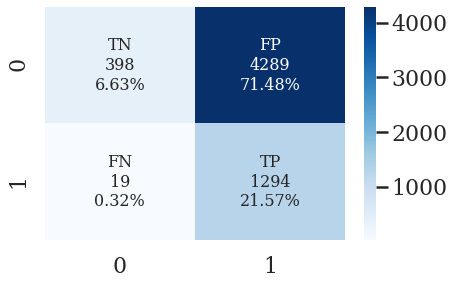

In [29]:
gnb2 = GaussianNB().fit(X_tr2, y_tr)
y_pred_gnb_tr2 = gnb2.predict(X_tr2)
y_pred_gnb_val2 = gnb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gnb_tr2, y_pred_gnb_val2, gnb2)

## <a id='36'>Linear Discriminant Analysis Classifier</a>

Training Accuracy:  0.8211904761904761
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.47984485385787495
Validation F1 Score:  0.4632936507936508
Training AUC Score:  0.7603052309200976
Validation AUC Score:  0.7512464594344747
Training Recall Score:  0.37199312714776633
Validation Recall Score:  0.3556740289413557
Training Precision Score:  0.6757705813499805
Validation Precision Score:  0.6642958748221907
Training Average Precision Score:  0.5346639484754171
Validation Average Precision Score:  0.5075309714254697

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.68      0.37      0.48      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.66      0.69     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0

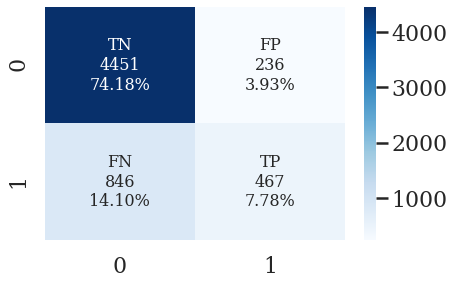

In [30]:
lda2 = LinearDiscriminantAnalysis().fit(X_tr2, y_tr)
y_pred_lda_tr2 = lda2.predict(X_tr2)
y_pred_lda_val2 = lda2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_lda_tr2, y_pred_lda_val2, lda2)

## <a id='37'>AdaBoost Classifier</a>

Training Accuracy:  0.8196666666666667
Validation Accuracy:  0.8166666666666667
Training F1 Score:  0.44996368917937546
Validation F1 Score:  0.4312306101344364
Training AUC Score:  0.7930457234534821
Validation AUC Score:  0.7743861706253998
Training Recall Score:  0.3326890034364261
Validation Recall Score:  0.3175932977913176
Training Precision Score:  0.6949304620906236
Validation Precision Score:  0.6714975845410628
Training Average Precision Score:  0.5631413361837274
Validation Average Precision Score:  0.5246419073439884

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.69      0.33      0.45      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

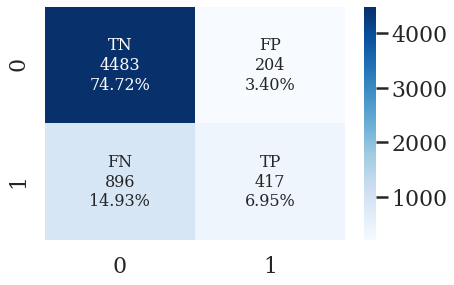

In [31]:
abc2 = AdaBoostClassifier().fit(X_tr2, y_tr)
y_pred_abc_tr2 = abc2.predict(X_tr2)
y_pred_abc_val2 = abc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_abc_tr2, y_pred_abc_val2, abc2)

## <a id='38'>Gradient Boosting Classifier</a>

Training Accuracy:  0.8292857142857143
Validation Accuracy:  0.8195
Training F1 Score:  0.503256200637384
Validation F1 Score:  0.4614619592242665
Training AUC Score:  0.8135581730866273
Validation AUC Score:  0.783553170271648
Training Recall Score:  0.3900343642611684
Validation Recall Score:  0.3533891850723534
Training Precision Score:  0.7090980085903944
Validation Precision Score:  0.664756446991404
Training Average Precision Score:  0.6118177347842763
Validation Average Precision Score:  0.5452949448592083

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84      

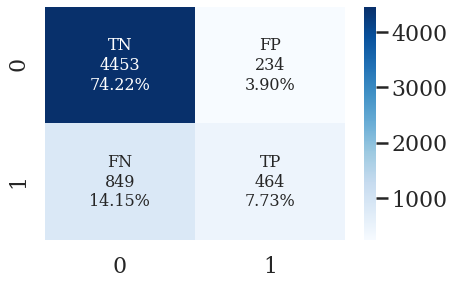

In [32]:
gbc2 = GradientBoostingClassifier().fit(X_tr2, y_tr)
y_pred_gbc_tr2 = gbc2.predict(X_tr2)
y_pred_gbc_val2 = gbc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gbc_tr2, y_pred_gbc_val2, gbc2)

## <a id='39'>XGBoost Classifier</a>

[09:10:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.8996190476190477
Validation Accuracy:  0.8126666666666666
Training F1 Score:  0.7272962483829236
Validation F1 Score:  0.4590952839268527
Training AUC Score:  0.9578797648768824
Validation AUC Score:  0.7654252960376702
Training Recall Score:  0.6037371134020618
Validation Recall Score:  0.3632901751713633
Training Precision Score:  0.9144437215354587
Validation Precision Score:  0.6235294117647059
Training Average Precision Score:  0.8865483898064123
Validation Average Precision Score:  0.5210374390704509

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     16344
           1

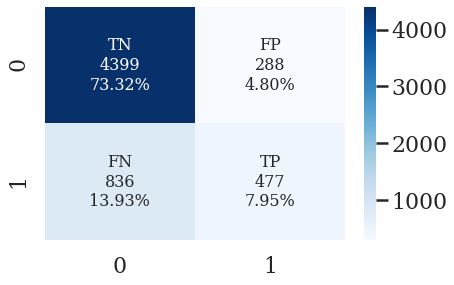

In [33]:
xgb2 = XGBClassifier().fit(X_tr2, y_tr)
y_pred_xgb_tr2 = xgb2.predict(X_tr2)
y_pred_xgb_val2 = xgb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_xgb_tr2, y_pred_xgb_val2, xgb2)

# <a id='4'> Feature Selection</a>

## <a id='41'>Decision Tree (CART) Feature Importance</a>

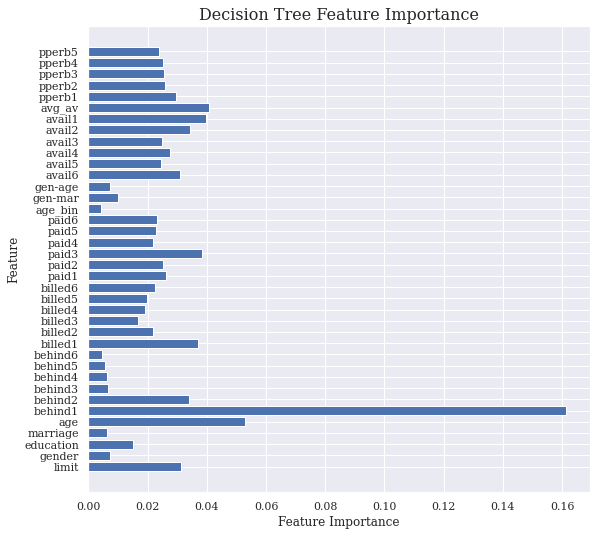

In [55]:
# sns.set_theme(style="darkgrid", font='serif', context='notebook')
# plot_feature_importances(X_train2, dtc2)
# plt.title("Decision Tree Feature Importance", size=16)
# plt.savefig('../images/dtc2_feature_importance.png')

## <a id='42'>Random Forest Feature Importance</a>

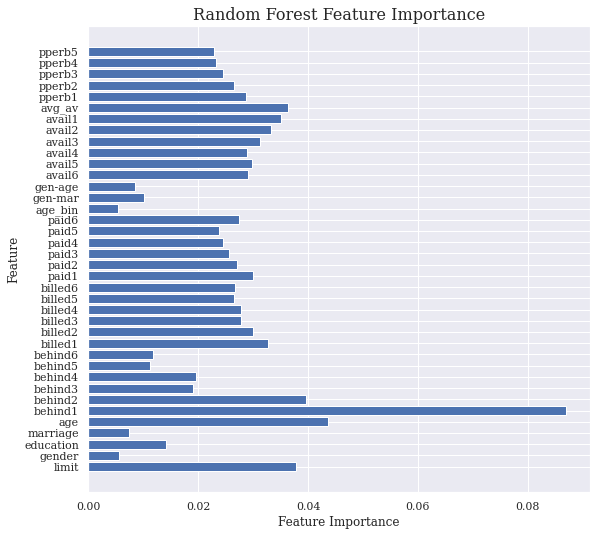

In [56]:
# plot_feature_importances(X_train2, rfc2)
# plt.title("Random Forest Feature Importance", size=16)
# plt.savefig('../images/rf_feature_importance.png')

## <a id='43'>XGBoost Feature Importance</a>

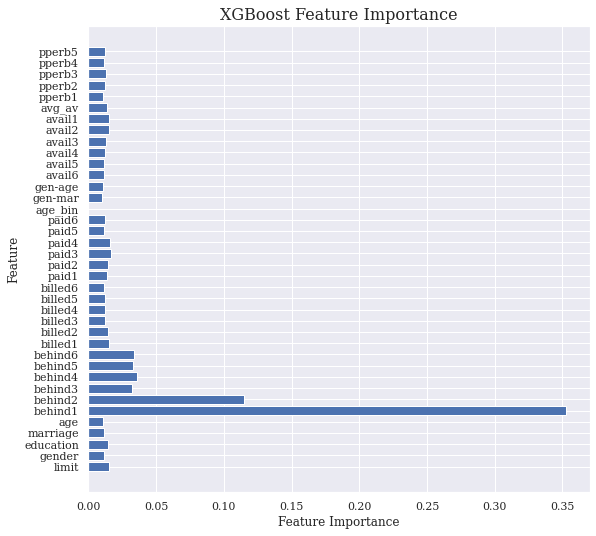

In [57]:
# plot_feature_importances(X_train2, xgb2)
# plt.title("XGBoost Feature Importance", size=16)
# plt.savefig('../images/xgb_feature_importance.png')

## <a id='39'>Recursive Feature Elimination with Cross-Validation</a>

Feature Ranking For Non-Discretised: [ 3 28 20 27 19  1 18  7 13 21  2 15 14  9 22 33 10  6  1 35 23 32 17 26
  8 37 11 12 29 16  4  5 34 30 25 24 36 31]
Optimal number of features : 2


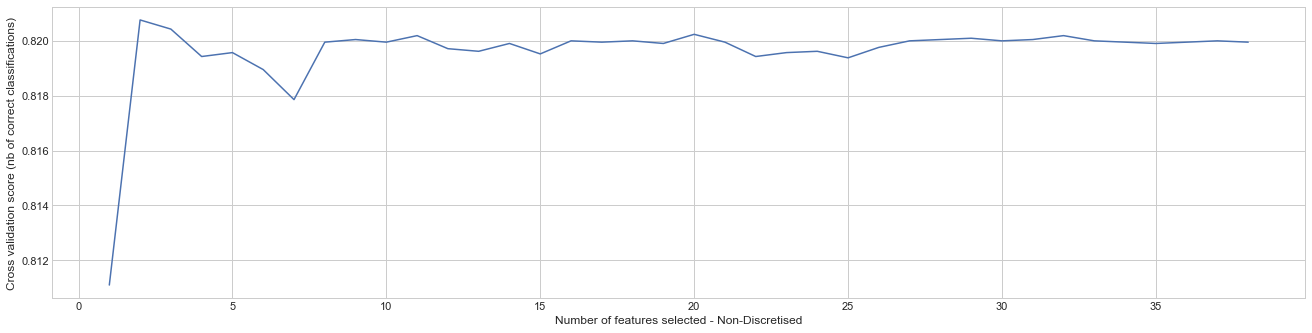

In [58]:
# from sklearn.feature_selection import RFECV
# rfe = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1).fit(X_tr2, y_tr)
# print("Feature Ranking For Non-Discretised: %s" % rfe.ranking_)
# print("Optimal number of features : %d" % rfe.n_features_)

# plt.style.use('seaborn-whitegrid')
# plt.figure(figsize=(20,5)) 
# plt.xlabel("Number of features selected - Non-Discretised")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_);



In [59]:
# selected = X_train2.columns[rfe.support_]
# print(selected)

Index(['behind1', 'paid2'], dtype='object')


In [ ]:
train2 = pd.read_csv("../data/train_feature.csv")
validate2 = pd.read_csv("../data/validate_feature.csv")
train3 = train2.drop(["gender","education", "marriage", "behind4", "behind5", "behind6", "gen-age", "gen-mar", "age_bin", "pperb1", "pperb2", "pperb3", "pperb4", "pperb5"], axis=1)
validate3 = validate2.drop(["gender","education", "marriage", "behind4", "behind5", "behind6", "gen-age", "gen-mar", "age_bin", "pperb1", "pperb2", "pperb3", "pperb4", "pperb5"], axis=1)

# <a id='5'>Discussion of Evaluation Metrics</a>

In [41]:
data = {'Accuracy': [accuracy(y_val, y_pred_log_val), 
                     accuracy(y_val, y_pred_rfc_val), 
                     accuracy(y_val, y_pred_dtc_val), 
                     accuracy(y_val, y_pred_knn_val), 
                     accuracy(y_val, y_pred_gnb_val), 
                     accuracy(y_val, y_pred_lda_val), 
                     accuracy(y_val, y_pred_abc_val), 
                     accuracy(y_val, y_pred_gbc_val),
                     accuracy(y_val, y_pred_xgb_val)],
        'F1 Score': [f1(y_val, y_pred_log_val), 
                     f1(y_val, y_pred_rfc_val), 
                     f1(y_val, y_pred_dtc_val), 
                     f1(y_val, y_pred_knn_val), 
                     f1(y_val, y_pred_gnb_val), 
                     f1(y_val, y_pred_lda_val), 
                     f1(y_val, y_pred_abc_val), 
                     f1(y_val, y_pred_gbc_val),
                     f1(y_val, y_pred_xgb_val)],
        'ROC AUC': [auc(X_val, y_val, logreg),
                      auc(X_val, y_val, rfc),
                      auc(X_val, y_val, dtc),
                      auc(X_val, y_val, knn),
                      auc(X_val, y_val, gnb),
                      auc(X_val, y_val, lda),
                      auc(X_val, y_val, abc),
                      auc(X_val, y_val, gbc),
                      auc(X_val, y_val, xgb)],
        'Recall': [recall(y_val, y_pred_log_val), 
                   recall(y_val, y_pred_rfc_val), 
                   recall(y_val, y_pred_dtc_val), 
                   recall(y_val, y_pred_knn_val), 
                   recall(y_val, y_pred_gnb_val), 
                   recall(y_val, y_pred_lda_val), 
                   recall(y_val, y_pred_abc_val),
                   recall(y_val, y_pred_gbc_val),
                   recall(y_val, y_pred_xgb_val)],
        'Precision': [precision(y_val, y_pred_log_val), 
                      precision(y_val, y_pred_rfc_val), 
                      precision(y_val, y_pred_dtc_val), 
                      precision(y_val, y_pred_knn_val), 
                      precision(y_val, y_pred_gnb_val),
                      precision(y_val, y_pred_lda_val), 
                      precision(y_val, y_pred_abc_val),
                      precision(y_val, y_pred_gbc_val),
                      precision(y_val, y_pred_xgb_val)],
        'PR AUC': [aps(X_val, y_val, logreg),
                   aps(X_val, y_val, rfc),
                   aps(X_val, y_val, dtc),
                   aps(X_val, y_val, knn),
                   aps(X_val, y_val, gnb),
                   aps(X_val, y_val, lda),
                   aps(X_val, y_val, abc),
                   aps(X_val, y_val, gbc),
                   aps(X_val, y_val, xgb)]}
scores = pd.DataFrame(data=data, index = ['Logistic Regression', 
                                          'Random Forest Classifier', 
                                          'Decision Tree Classifier', 
                                          'K-Nearest Neighbors', 
                                          'Gaussian Naive Bayes', 
                                          'Linear Discriminant Analysis', 
                                          'AdaBoost Classifier', 
                                          'Gradient Boosting Classifier',
                                          'XGBoost Classifier'])

In [42]:
data = {'Accuracy': [accuracy(y_val, y_pred_log_val2), 
                     accuracy(y_val, y_pred_rfc_val2), 
                     accuracy(y_val, y_pred_dtc_val2), 
                     accuracy(y_val, y_pred_knn_val2), 
                     accuracy(y_val, y_pred_gnb_val2), 
                     accuracy(y_val, y_pred_lda_val2), 
                     accuracy(y_val, y_pred_abc_val2), 
                     accuracy(y_val, y_pred_gbc_val2),
                     accuracy(y_val, y_pred_xgb_val2)],
        'F1 Score': [f1(y_val, y_pred_log_val2), 
                     f1(y_val, y_pred_rfc_val2), 
                     f1(y_val, y_pred_dtc_val2), 
                     f1(y_val, y_pred_knn_val2), 
                     f1(y_val, y_pred_gnb_val2), 
                     f1(y_val, y_pred_lda_val2), 
                     f1(y_val, y_pred_abc_val2), 
                     f1(y_val, y_pred_gbc_val2),
                     f1(y_val, y_pred_xgb_val2)],
        'ROC AUC': [auc(X_val2, y_val, logreg2),
                    auc(X_val2, y_val, rfc2),
                    auc(X_val2, y_val, dtc2),
                    auc(X_val2, y_val, knn2),
                    auc(X_val2, y_val, gnb2),
                    auc(X_val2, y_val, lda2),
                    auc(X_val2, y_val, abc2),
                    auc(X_val2, y_val, gbc2),
                    auc(X_val2, y_val, xgb2)],
        'Recall': [recall(y_val, y_pred_log_val2), 
                   recall(y_val, y_pred_rfc_val2), 
                   recall(y_val, y_pred_dtc_val2), 
                   recall(y_val, y_pred_knn_val2), 
                   recall(y_val, y_pred_gnb_val2), 
                   recall(y_val, y_pred_lda_val2), 
                   recall(y_val, y_pred_abc_val2),
                   recall(y_val, y_pred_gbc_val2),
                   recall(y_val, y_pred_xgb_val2)],
        'Precision': [precision(y_val, y_pred_log_val2), 
                      precision(y_val, y_pred_rfc_val2), 
                      precision(y_val, y_pred_dtc_val2), 
                      precision(y_val, y_pred_knn_val2), 
                      precision(y_val, y_pred_gnb_val2),
                      precision(y_val, y_pred_lda_val2), 
                      precision(y_val, y_pred_abc_val2),
                      precision(y_val, y_pred_gbc_val2),
                      precision(y_val, y_pred_xgb_val2)],
        'PR AUC': [aps(X_val2, y_val, logreg2),
                   aps(X_val2, y_val, rfc2),
                   aps(X_val2, y_val, dtc2),
                   aps(X_val2, y_val, knn2),
                   aps(X_val2, y_val, gnb2),
                   aps(X_val2, y_val, lda2),
                   aps(X_val2, y_val, abc2),
                   aps(X_val2, y_val, gbc2),
                   aps(X_val2, y_val, xgb2)]}
scores2 = pd.DataFrame(data=data, index = ['Logistic Regression', 
                                          'Random Forest Classifier', 
                                          'Decision Tree Classifier', 
                                          'K-Nearest Neighbors', 
                                          'Gaussian Naive Bayes', 
                                          'Linear Discriminant Analysis', 
                                          'AdaBoost Classifier', 
                                          'Gradient Boosting Classifier',
                                          'XGBoost Classifier'])

In [44]:
scores

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression,0.816833,0.437276,0.761357,0.325209,0.667188,0.513066
Random Forest Classifier,0.816167,0.461689,0.759151,0.360244,0.642663,0.514929
Decision Tree Classifier,0.726333,0.382707,0.604865,0.387662,0.377877,0.280732
K-Nearest Neighbors,0.795000,0.440909,0.703475,0.369383,0.546787,0.419740
Gaussian Naive Bayes,0.765667,0.509763,0.745857,0.556740,0.470096,0.483411
Linear Discriminant Analysis,0.819667,0.464356,0.757568,0.357197,0.663366,0.511784
AdaBoost Classifier,0.815333,0.423517,0.776288,0.309977,0.668309,0.524765
Gradient Boosting Classifier,0.819833,0.464586,0.781359,0.357197,0.664306,0.547847
XGBoost Classifier,0.814333,0.464938,0.763101,0.368621,0.629389,0.521935


In [45]:
scores2

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression,0.816333,0.432544,0.755982,0.319878,0.667727,0.509078
Random Forest Classifier,0.815500,0.461314,0.755349,0.361005,0.638814,0.512912
Decision Tree Classifier,0.720833,0.386222,0.605721,0.401371,0.372175,0.280380
K-Nearest Neighbors,0.792500,0.429684,0.701184,0.357197,0.539080,0.406997
Gaussian Naive Bayes,0.282000,0.375290,0.728544,0.985529,0.231775,0.472259
Linear Discriminant Analysis,0.819667,0.463294,0.751246,0.355674,0.664296,0.507531
AdaBoost Classifier,0.816667,0.431231,0.774386,0.317593,0.671498,0.524642
Gradient Boosting Classifier,0.819500,0.461462,0.783553,0.353389,0.664756,0.545295
XGBoost Classifier,0.812667,0.459095,0.765425,0.363290,0.623529,0.521037
